In [209]:
import pandas as pd
import itertools

excel_path_and_filename = "../../../Downloads/SMEs_Scopus_2013-2017.xlsx"
df = pd.read_excel(excel_path_and_filename)
df = df[['Author Keywords', 'Year', 'Abstract', 'Index Keywords']]

In [113]:
auth_kwd_lst = list(df['Author Keywords'].dropna().apply(lambda s: s.strip().split(";")))
auth_kwd_lst = map(lambda ks: [k.strip().lower() for k in ks], auth_kwd_lst)
auth_kwd_lst = list(auth_kwd_lst)

ind_kwd_lst = list(df['Index Keywords'].dropna().apply(lambda s: s.strip().split(";")))
ind_kwd_lst = map(lambda ks: [k.strip().lower() for k in ks], ind_kwd_lst)
ind_kwd_lst = list(ind_kwd_lst)

abs_lst = list(df[df['Abstract']!="[No abstract available]"]['Abstract'])
abs_lst = map(lambda s: s.strip().split(" "), abs_lst)
abs_lst = map(lambda ws: [k.strip().lower() for k in ws] , abs_lst)
abs_lst = list(abs_lst)

In [372]:
from inflection import singularize 
import nltk
import difflib
from collections import Counter
import itertools 

def total_count(input_df, column_name='Author Keywords'):
    # 'Author Keywords' or 'Noun Phrases'
    r = itertools.chain.from_iterable(input_df[column_name])
    r = Counter(r).most_common()
    return pd.DataFrame(r, columns=[column_name, 'count'])
def make_kwd_change_dict(l_of_l, non_app_keys):
    kwd_counter = itertools.chain.from_iterable(list(auth_kwd_df['Author Keywords']))
    kwd_counter = Counter(total_c).most_common()
    kwd_counter = {w:c for w, c in kwd_counter}

    kwd_changed_dict = {}
    for w1 in sorted(kwd_counter.keys()):
        for w2 in sorted(kwd_counter.keys()):
            if w1 < w2:# 중복으로 계산하는 것을 피하기 위함
                sim_v = difflib.SequenceMatcher(None,w1, w2).ratio()
                if sim_v >= 0.90:
                    if kwd_counter[w1] >= kwd_counter[w2]:
                        kwd_changed_dict[w2]=w1
                        #print("{} ==> {}".format(w2, w1))
                    else:
                        #print("{} ==> {}".format(w1, w2))
                        kwd_changed_dict[w1]=w2
    """
    적합하지 않은 key는 제외함
    """
    new_kwd_changed_dict = filter(lambda k: True if k[0] not in non_app_keys else False, kwd_changed_dict.items())
    new_kwd_changed_dict = {k:v for k, v in new_kwd_changed_dict}
    """
    아래와 같은 상황이 발생할 수 있다. 결국 D 또한 B로 변환되면 되는데, 변환되기 위해서는 
    D ==> C, C==>A, A==B 의 세번 의 과정을 거쳐야 하는 것. 이러한 transivity를 dictionary에서 제외해준다. 

    A: small medium enterprise
    B: small and medium enterprise
    C: small medium enterprise sme
    D: small medium enterprises sme

    A ==> B
    C ==> A
    D ==> C
    """
    non_transvitiy_kwd_dict = {}
    for k, v in new_kwd_changed_dict.items():
        while v in new_kwd_changed_dict.keys():
            v = new_kwd_changed_dict[v]
        non_transvitiy_kwd_dict[k] = v
    return non_transvitiy_kwd_dict
def filtering_auth_kwds(input_df,column_name='Author Keywords', above_n=3):
    print("original unique keyword len: {}".format(
        len(set(itertools.chain.from_iterable(list(input_df[column_name]))))
    ))
    input_df[column_name] = input_df[column_name].apply(lambda ks: [k.strip().lower() for k in ks])
    # edge를 만들때 중복을 방지하기 위해서 sorting해둔다. 
    input_df[column_name] = input_df[column_name].apply(lambda l: sorted(list(set(l))))
    """
    특수문자 삭제: 0-9 이거나, 'a' - 'z'가 아니면 다 삭제. 
    """
    def replace_sp_chr(input_s):
        return "".join(map(lambda c: c if 'a'<=c and c<='z' else c if '0'<=c and c<='9'else " ", input_s)).strip()
    def remove_double_space(input_s):
        while "  " in input_s:
            input_s = input_s.replace("  ", " ")
        return input_s
    input_df[column_name] = input_df[column_name].apply(
        lambda ks: list(map(
            lambda k: remove_double_space(replace_sp_chr(k)), ks)))
    """
    단수 복수 처리: singularized 가 이미 키워드 세트에 포함되어 있을때에만 변형
    """
    all_kwd_set = set(itertools.chain.from_iterable(list(input_df[column_name])))
    to_singular_dict = {}
    for kwd in all_kwd_set:
        singularized_kwd = singularize(kwd)
        if singularized_kwd !=kwd and singularized_kwd in all_kwd_set:
            to_singular_dict[kwd] = singularized_kwd
    input_df[column_name] = input_df[column_name].apply(
        lambda ks: list(map(
            lambda k: to_singular_dict[k] if k in to_singular_dict.keys() else k, ks
        ))
    )
    """
    형태에 따른 키워드 유사도를 평가하여 변환한다. 
    적합하지 않은 키워드는 아래에서 직접 넣어주는 것이 필요함
    """
    non_app_keys = ['lean production', 'coopetition'] ## 여기에 직접 넣어줌.
    kwd_change_dict = make_kwd_change_dict(list(input_df[column_name]), non_app_keys)
    input_df[column_name] = input_df[column_name].apply(
        lambda ks: list(map(
            lambda k: kwd_change_dict[k] if k in kwd_change_dict.keys() else k, ks
        ))
    )
    """
    개별 node가 전체에서 1번 밖에 등장하지 않는 경우도 많은데, 이를 모두 고려해서 분석을 하면, 효율적이지 못한 계산이 된다. 
    따라서, 빈도가 일정 이상을 넘는 경우에 대해서만 고려하여 df를 수정하는 것이 필요하다. 
    """
    filtered_kwds = total_count(input_df, column_name=column_name)
    filtered_kwds = set(filtered_kwds[filtered_kwds['count']>=above_n][column_name])
    input_df[column_name] = input_df[column_name].apply(lambda ks: list(filter(lambda k: True if k in filtered_kwds else False, ks)))
    """
    word embedding 등 다른 데이터 전처리가 필요하다면 여기서 처리하는 것이 좋음. 
    """
    """
    리스트 내부 중복 삭제
    """
    input_df[column_name] = input_df[column_name].apply(
        lambda ks: list(set(ks))
    )
    """
    검색 키워드의 중심에서 거리상으로 측정했을때, 가장 먼 shortest path를 제외하는 등으로의 방식으로도 수행할 수 있지 않을까? 
    """
    print("after filtering, unique keyword len: {}".format(
        len(set(itertools.chain.from_iterable(list(input_df[column_name]))))
    ))
    #print(input_df.head())
    return input_df# 사실 굳이 return을 쓸 필요가 없음. 이미 내부에서 다 바꿔줌. 
auth_kwd_lst = list(df['Author Keywords'].dropna().apply(lambda s: s.strip().split(";")))
auth_kwd_lst = map(lambda ks: [k.strip().lower() for k in ks], auth_kwd_lst)
auth_kwd_lst = list(auth_kwd_lst)
auth_kwd_df = pd.DataFrame({'Author Keywords':auth_kwd_lst})
print(auth_kwd_df.head())
auth_kwd_df = filtering_auth_kwds(auth_kwd_df, column_name='Author Keywords', above_n=5)
#print(auth_kwd_df.head())

                                     Author Keywords
0  [csfs, factor analysis, indian manufacturing s...
1  [energy recovery, muzzle arc, pulsed supply, r...
2  [internationalization, market research, organi...
3   [contractors, entrepreneurship, indonesia, smes]
4  [bpgm-sme, improved ukf, multi-target tracking...
original unique keyword len: 24200
after filtering, unique keyword len: 1337


In [268]:
w_set = set(itertools.chain.from_iterable(list(auth_kwd_df['Author Keywords'])))
for w1 in w_set:
    for w2 in w_set:
        if w1 != w2 and len(w1) >=5 and len(w2) >=5:# 그냥 최소한 5개는 되어야 하지 않나 싶어서...
            if difflib.SequenceMatcher(None, w1, w2).ratio() > 0.95:
                print("{} ==> {}".format(w1, w2))

# 전체 값에 대해서 플로팅을 해보면 갑자기 확 주러드는 거라든가, 그런게 있지 않을까? 
# plottingg 해보면 어떻게 되나? 

small medium enterprise sme ==> small medium enterprises sme
organizational culture ==> organisational culture
organizational performance ==> organisational performance
small and medium sized enterprises sme ==> small and medium sized enterprise sme
structural equation modeling ==> structural equation modelling
small medium enterprises sme ==> small medium enterprise sme
small and medium enterprise sme ==> small and medium enterprises sme
small and medium sized enterprise ==> small and medium size enterprise
smes performance ==> sme performance
small and medium sized enterprise sme ==> small and medium sized enterprises sme
organisational performance ==> organizational performance
small and medium enterprises sme ==> small and medium enterprise sme
structural equation modelling ==> structural equation modeling
organisational culture ==> organizational culture
small and medium size enterprise ==> small and medium sized enterprise
sme performance ==> smes performance


In [367]:
"""
키워드간를 변경할 때는 키워드의 수 또한 중요하게 고려해야 하지 않나, 더 많은 놈으로 변경한다. 
"""
import nltk
import difflib
from collections import Counter
import itertools 
import matplotlib.pyplot as plt
"""
sequence matcher ratio의 전체 분포를 한 번 보자 .
"""
"""
plot the word sequence similarity distribution 

a = (difflib.SequenceMatcher(None, w1, w2).ratio() for w1 in kwd_counter.keys() for w2 in kwd_counter.keys())
# draw boxplot required 
a = filter(lambda x: True if x!=1.0 else False, a)
plt.figure(figsize=(15, 6))
plt.plot(sorted(a), 'ro')
plt.show()
"""

def make_kwd_change_dict(l_of_l, non_app_keys):
    kwd_counter = itertools.chain.from_iterable(list(auth_kwd_df['Author Keywords']))
    kwd_counter = Counter(total_c).most_common()
    kwd_counter = {w:c for w, c in kwd_counter}

    kwd_changed_dict = {}
    for w1 in sorted(kwd_counter.keys()):
        for w2 in sorted(kwd_counter.keys()):
            if w1 < w2:# 중복으로 계산하는 것을 피하기 위함
                sim_v = difflib.SequenceMatcher(None,w1, w2).ratio()
                if sim_v >= 0.90:
                    if kwd_counter[w1] >= kwd_counter[w2]:
                        kwd_changed_dict[w2]=w1
                        #print("{} ==> {}".format(w2, w1))
                    else:
                        #print("{} ==> {}".format(w1, w2))
                        kwd_changed_dict[w1]=w2
    """
    적합하지 않은 key는 제외함
    """
    new_kwd_changed_dict = filter(lambda k: True if k[0] not in non_app_keys else False, kwd_changed_dict.items())
    new_kwd_changed_dict = {k:v for k, v in new_kwd_changed_dict}
    """
    아래와 같은 상황이 발생할 수 있다. 결국 D 또한 B로 변환되면 되는데, 변환되기 위해서는 
    D ==> C, C==>A, A==B 의 세번 의 과정을 거쳐야 하는 것. 이러한 transivity를 dictionary에서 제외해준다. 

    A: small medium enterprise
    B: small and medium enterprise
    C: small medium enterprise sme
    D: small medium enterprises sme

    A ==> B
    C ==> A
    D ==> C
    """
    non_transvitiy_kwd_dict = {}
    for k, v in new_kwd_changed_dict.items():
        while v in new_kwd_changed_dict.keys():
            v = new_kwd_changed_dict[v]
        non_transvitiy_kwd_dict[k] = v

    for k, v in non_transvitiy_kwd_dict.items():
        print("{} ==> {}".format(k, v))
    return non_transvitiy_kwd_dict
make_kwd_change_dict(list(auth_kwd_df['Author Keywords']), non_app_keys=['lean production', 'coopetition'])

competence ==> competency
corporate social responsibility csr ==> corporate social responsibility
enterprise resource planning erp ==> enterprise resource planning
globalisation ==> globalization
internationalisation ==> internationalization
sme internationalization ==> internationalization
modelling ==> modeling
product development ==> new product development
organisational culture ==> organizational culture
organisational performance ==> organizational performance
shape memory effect sme ==> shape memory effect
small and medium enterprise sme ==> small and medium sized enterprise
small and medium enterprises sme ==> small and medium sized enterprise
small and medium scale enterprise ==> small and medium sized enterprise
small and medium size enterprise ==> small and medium sized enterprise
small and medium enterprise ==> small and medium sized enterprise
small medium enterprise ==> small and medium sized enterprise
small to medium enterprise ==> small and medium sized enterprise
smal

{'competence': 'competency',
 'corporate social responsibility csr': 'corporate social responsibility',
 'enterprise resource planning erp': 'enterprise resource planning',
 'globalisation': 'globalization',
 'internationalisation': 'internationalization',
 'modelling': 'modeling',
 'organisational culture': 'organizational culture',
 'organisational performance': 'organizational performance',
 'product development': 'new product development',
 'shape memory effect sme': 'shape memory effect',
 'small and medium enterprise': 'small and medium sized enterprise',
 'small and medium enterprise sme': 'small and medium sized enterprise',
 'small and medium enterprises sme': 'small and medium sized enterprise',
 'small and medium scale enterprise': 'small and medium sized enterprise',
 'small and medium size enterprise': 'small and medium sized enterprise',
 'small and medium sized enterprise sme': 'small and medium sized enterprise',
 'small and medium sized enterprises sme': 'small and med

competence ==> competency
corporate social responsibility csr ==> corporate social responsibility
enterprise resource planning erp ==> enterprise resource planning
globalisation ==> globalization
internationalisation ==> internationalization
sme internationalization ==> internationalization
modelling ==> modeling
product development ==> new product development
organisational culture ==> organizational culture
organisational performance ==> organizational performance
shape memory effect sme ==> shape memory effect
small and medium enterprise sme ==> small and medium sized enterprise
small and medium enterprises sme ==> small and medium sized enterprise
small and medium scale enterprise ==> small and medium sized enterprise
small and medium size enterprise ==> small and medium sized enterprise
small and medium enterprise ==> small and medium sized enterprise
small medium enterprise ==> small and medium sized enterprise
small to medium enterprise ==> small and medium sized enterprise
smal

'\n아래와 같은 상황이 발생할 수 있다. 결국 D 또한 B로 변환되면 되는데, 변환되기 위해서는 \nD ==> C, C==>A, A==B 의 세번 의 과정을 거쳐야 하는 것. 이러한 transivity를 dictionary에서 제외해준다. \n\nA: small medium enterprise\nB: small and medium enterprise\nC: small medium enterprise sme\nD: small medium enterprises sme\n\nA ==> B\nC ==> A\nD ==> C \n'

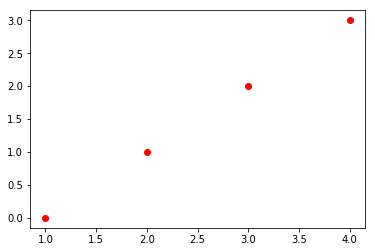

In [316]:
import matplotlib.pyplot as plt
import numpy as np

a = sorted([1,2,3,4])
plt.figure()
plt.plot(a, range(0, len(a)), 'ro')
plt.show()

In [266]:
import nltk
import difflib
w1 = "small and medium enterprise"
w2 = "small and medium enterprise sme"
print(nltk.edit_distance(w1, w2))

seq = difflib.SequenceMatcher(None,w1, w2)
print(seq.ratio()) 
seq = difflib.SequenceMatcher(None,'ab', 'abc')
print(seq.ratio()) 
### OUTPUT: 87.323943

4
0.9310344827586207
0.8


In [ ]:
from nltk import sent_tokenize

abs_lst = list(df[df['Abstract']!="[No abstract available]"]['Abstract'])
sent_lst = itertools.chain.from_iterable(map(sent_tokenize, abs_lst))
#sent_lst = list(sent_lst)
sent_lst = map(lambda s: s.strip().lower(), sent_lst)
def replace_sp_chr(input_s):
    return "".join(map(lambda c: c if 'a'<=c and c<='z' else c if '0'<=c and c<='9'else " ", input_s)).strip()
def remove_double_space(input_s):
    while "  " in input_s:
        input_s = input_s.replace("  ", " ")
    return input_s
sent_lst = map(replace_sp_chr, sent_lst)
sent_lst = map(remove_double_space, sent_lst)
sent_lst = list(sent_lst)

In [236]:
"""
sent의 갯수만 10만 개. 
word2vec에 학습이야 그냥 리스트 오브 리스트로 넘기면 되는 건데, 여기서 vocabulary를 구성할지에 대한 문제가 있는거겠지?
일단 sentence를 어떻게 쪼갤 것인가의 문제. 그냥 스페이스로 쪼개면, 어느정도 비슷하게 학습이 되기는 하는데, 그게 뭐 의미가 있나?
아니면 저번에 noun_phrase를 쪼개준 것처럼 phrase단위로 쪼개준 다음에 
"""
# 
#
len(sent_lst)

105427

In [239]:
from nltk.corpus import movie_reviews
sentences = [list(s) for s in movie_reviews.sents()]

from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences, size=100) 
# 여기서 사이즈는 vector의 크기를 말합니다. nn의 최종 layer size라고 생각해도 됩니다. 
# 뉴럴넷의 사이즈를 좀 깊게 만들어보고 싶은데, gensim에서 자동으로 해주는지 모르겠네요. 
model.init_sims(replace=True)# 학습 완료 후, 필요없는 메모리 삭제 

print("vector of {}:".format('man'))
print(model.wv['man'])
for w1, w2 in [('actor', 'actress'), ('man', 'woman')]:
    print("similarity of {} and {}:".format(w1, w2))
    print(model.wv.similarity(w1, w2))

print()
print(model.wv.most_similar('man'))
print()
# actor + she - actress 
print(model.wv.most_similar(positive=['actor', 'she'], negative='actress', topn=1))
# actress + he - actor
print(model.wv.most_similar(positive=['actress', 'he'], negative='actor', topn=1))

vector of man:
[ 0.0961192   0.00437185  0.03467375  0.26454127  0.02940031  0.02288906
  0.02179242  0.02122602 -0.04023347  0.01882667 -0.02628091  0.03881754
 -0.06698899  0.14932805 -0.0474763   0.02154444 -0.14287125  0.21027721
 -0.02145271 -0.02302506  0.03378444  0.0153384   0.07713746  0.15382759
  0.12019698 -0.1113359  -0.0593212  -0.19330981  0.00104285 -0.08455317
  0.01631272  0.05338057 -0.05085417 -0.00311475  0.00962412  0.12170225
 -0.09533398  0.09420326 -0.03652238 -0.13428254 -0.13235193  0.12731819
  0.06866247  0.01878783  0.07961938 -0.02594641  0.1502616  -0.09824947
  0.11498301  0.03205505 -0.13049409 -0.11235102  0.18670972  0.20496006
  0.11508316 -0.08224259  0.07353425  0.05081542  0.07457628 -0.06560689
  0.06979878  0.00345675  0.15629113  0.11683072 -0.07166454 -0.08964456
  0.0704189   0.01116451 -0.07762457 -0.15145063 -0.23548466  0.17004918
 -0.08410266  0.05517555 -0.12813565  0.08467376  0.15465082 -0.01966195
 -0.126249    0.05783306 -0.10403755

In [247]:
model.vocabulary.sample

0.001

In [203]:
"""
bipartite graph를 구성해서 거기서부터, similarity를 뽑아낼 수 있지 않을까? 사실 그게 일종의 워드 임베딩 아닌가. 
원래 워드 임베딩은 개별 단어를 중심으로 하는 건데, 여기는 지금 그렇게 구성할 수 가 없을 것 같음. 

author kwd ==> index kwd 
author kwd ==> abstrac noun or verb (or both)

의 형태로 bipartite하게 구성할 수 있는데 이렇게 구성하여, structure equivalence를 만들 수 있지 않을까? 

아무튼 일단 워드 임베딩을 조금만 더 파서 정리는 마저 하는 것이 필요함. 
"""

'\nbipartite graph를 구성해서 거기서부터, similarity를 뽑아낼 수 있지 않을까? 사실 그게 일종의 워드 임베딩 아닌가. \n원래 워드 임베딩은 개별 단어를 중심으로 하는 건데, 여기는 지금 그렇게 구성할 수 가 없을 것 같음. \n\nauthor kwd ==> index kwd \nauthor kwd ==> abstrac noun or verb (or both)\n\n의 형태로 bipartite하게 구성할 수 있는데 이렇게 구성하여, structure equivalence를 만들 수 있지 않을까? \n\n아무튼 일단 워드 임베딩을 조금만 더 파서 정리는 마저 하는 것이 필요함. \n'

In [199]:
import gensim 
ss = ['I', 'am', 'a', 'good', 'boy'] 
bigram_transformer = gensim.models.phrases.Phraser([
    ss
])

AttributeError: 'list' object has no attribute 'threshold'

In [96]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(abs_lst)
model.init_sims(replace=True)# 학습 완료 후, 필요없는 메모리 삭제 
#model.most_similar("small and medium enterprises")

/Users/frhyme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """


KeyError: "word 'small and medium enterprises' not in vocabulary"

In [94]:
auth_counter = Counter(itertools.chain.from_iterable(auth_kwd_lst)).most_common()
count1_w = list(filter(lambda x: True if x[1]==5 else False, auth_counter))

In [95]:
for w in count1_w[:10]:
    print(w[0])
    try:
        print(model.most_similar(w[0]))
    except:
        continue
    print()

proximity
[('trust,', 0.7394723892211914), ('experience,', 0.7393851280212402), ('formality', 0.7343860864639282), ('embeddedness', 0.7326754927635193), ("owner's", 0.72593092918396), ('human,', 0.7258467674255371), ('income,', 0.720426619052887), ('structure,', 0.7192338109016418), ('knowledge)', 0.7186062932014465), ('loyalty', 0.717450737953186)]

fuzzy comprehensive evaluation
[('prosthetics', 0.9823917150497437), ('information systems security', 0.9795824289321899), ('wastewater treatment', 0.9777668118476868), ('natural language processing', 0.9777394533157349), ('credit evaluations', 0.977641761302948), ('agile methods', 0.9775588512420654), ('power cables', 0.9772118926048279), ('cost saving', 0.9771889448165894), ('drug blood level', 0.9763650298118591), ('drug bioavailability', 0.9759867787361145)]

spillovers
[('portfolios', 0.7346036434173584), ('appropriability', 0.7307323217391968), ('cross-border', 0.7283568978309631), ('breadth', 0.7144168615341187), ('mind-set', 0.7128

/Users/frhyme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


In [ ]:
from nltk.corpus import movie_reviews
sentences = [list(s) for s in movie_reviews.sents()]

[['plot',
  ':',
  'two',
  'teen',
  'couples',
  'go',
  'to',
  'a',
  'church',
  'party',
  ',',
  'drink',
  'and',
  'then',
  'drive',
  '.'],
 ['they', 'get', 'into', 'an', 'accident', '.'],
 ['one',
  'of',
  'the',
  'guys',
  'dies',
  ',',
  'but',
  'his',
  'girlfriend',
  'continues',
  'to',
  'see',
  'him',
  'in',
  'her',
  'life',
  ',',
  'and',
  'has',
  'nightmares',
  '.'],
 ['what', "'", 's', 'the', 'deal', '?'],
 ['watch', 'the', 'movie', 'and', '"', 'sorta', '"', 'find', 'out', '.'],
 ['.'],
 ['.'],
 ['critique',
  ':',
  'a',
  'mind',
  '-',
  'fuck',
  'movie',
  'for',
  'the',
  'teen',
  'generation',
  'that',
  'touches',
  'on',
  'a',
  'very',
  'cool',
  'idea',
  ',',
  'but',
  'presents',
  'it',
  'in',
  'a',
  'very',
  'bad',
  'package',
  '.'],
 ['which',
  'is',
  'what',
  'makes',
  'this',
  'review',
  'an',
  'even',
  'harder',
  'one',
  'to',
  'write',
  ',',
  'since',
  'i',
  'generally',
  'applaud',
  'films',
  'which',

In [ ]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences)
model.init_sims(replace=True)# 학습 완료 후, 필요없는 메모리 삭제 

In [101]:
sentences = [
    ["a", 'is', 'not', 'b'], ['b', 'is', 'c']
]
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences)
model.init_sims(replace=True)# 학습 완료 후, 필요없는 메모리 삭제 
model.most_similar('a')

RuntimeError: you must first build vocabulary before training the model